In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score,precision_score,confusion_matrix
import joblib
from joblib import load
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/processed-bmc-512-data/dataset_final/Y_test.csv
/kaggle/input/processed-bmc-512-data/dataset_final/X_test.csv
/kaggle/input/processed-bmc-512-data/dataset_final/Y_train.csv
/kaggle/input/processed-bmc-512-data/dataset_final/X_train.csv
/kaggle/input/processed-bmc-512-data/dataset_final/Y_cv.csv
/kaggle/input/processed-bmc-512-data/dataset_final/X_cv.csv
/kaggle/input/preprocessing_models/other/default/1/models_for_preprocessing/scaler.joblib
/kaggle/input/preprocessing_models/other/default/1/models_for_preprocessing/pca.joblib
/kaggle/input/preprocessing_models/other/default/1/models_for_preprocessing/tfidf_vectorizer.joblib


In [2]:
X_train=pd.read_csv('/kaggle/input/processed-bmc-512-data/dataset_final/X_train.csv')
Y_train=pd.read_csv('/kaggle/input/processed-bmc-512-data/dataset_final/Y_train.csv')

In [3]:
X_cv=pd.read_csv('/kaggle/input/processed-bmc-512-data/dataset_final/X_cv.csv')
Y_cv=pd.read_csv('/kaggle/input/processed-bmc-512-data/dataset_final/Y_cv.csv')

In [4]:
X_test=pd.read_csv('/kaggle/input/processed-bmc-512-data/dataset_final/X_test.csv')
Y_test=pd.read_csv('/kaggle/input/processed-bmc-512-data/dataset_final/Y_test.csv')

In [5]:
params={
    'random_state':69,
    'max_iter': 100,
    'solver':'liblinear',
    'penalty':'l1',
}

In [6]:
model=LogisticRegression(**params)

In [7]:
model.fit(X_train,Y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(penalty='l1', random_state=69, solver='liblinear')

# Converting X_cv Data to suitable format

In [8]:
vectorizer = load('/kaggle/input/preprocessing_models/other/default/1/models_for_preprocessing/tfidf_vectorizer.joblib')   # e.g., CountVectorizer or TfidfVectorizer
scaler = load('/kaggle/input/preprocessing_models/other/default/1/models_for_preprocessing/scaler.joblib')           # e.g., StandardScaler or MinMaxScaler
pca = load('/kaggle/input/preprocessing_models/other/default/1/models_for_preprocessing/pca.joblib')

In [9]:
tfidf_matrix_cv = vectorizer.transform(X_cv['Ad Topic Line'])

# Convert the result to a DataFrame for easy inspection
tfidf_df_cv = pd.DataFrame(tfidf_matrix_cv.toarray().astype(int), columns=vectorizer.get_feature_names_out())
X_cv.reset_index(inplace=True)
X_cv.drop('index',axis=1,inplace=True)
# Optionally, concatenate these features back to your original DataFrame
X_cv = pd.concat([X_cv, tfidf_df_cv], axis=1)

In [10]:
X_cv=X_cv.drop('Ad Topic Line',axis=1)

In [11]:
X_cv.drop([
    'Daily Internet Usage_squared',
    'Daily Internet Usage_cubed',
    'Daily Internet Usage_to_the_fourth_power',
    'Daily Time Spent on Site_squared',
    'Daily Time Spent on Site_cubed',
    'Daily Time Spent on Site_to_the_fourth_power'
],axis=1,inplace=True)

In [12]:
not_cat_cols=[
    'Daily Time Spent on Site',
    'Daily Internet Usage',
    'Area Income_negated_sqrt',
    'Age_log_transformed'
]

In [13]:
cat_cols=list(set(X_cv.columns)-set(not_cat_cols))

In [14]:
transformed_not_cal_data_cv=scaler.transform(X_cv[not_cat_cols])

In [15]:
scaled_X_cv=pd.concat([pd.DataFrame(transformed_not_cal_data_cv,columns=not_cat_cols),X_cv[cat_cols]],axis=1)

In [16]:
pca_data_cv=pca.transform(scaled_X_cv[['Daily Time Spent on Site','Daily Internet Usage']])

In [17]:
X_cv=pd.concat([pd.Series(pca_data_cv.flatten(),name='pca_data'),scaled_X_cv.drop(['Daily Time Spent on Site','Daily Internet Usage'],axis=1)],axis=1)

In [18]:
X_cv['pca_data_squared']=X_cv['pca_data']**2
X_cv['pca_data_cubed']=X_cv['pca_data']**3
X_cv['pca_data_to_the_fourth_power']=X_cv['pca_data']**4

In [19]:
X_cv=X_cv[X_train.columns]

# Testing Data

In [20]:
tfidf_matrix_test = vectorizer.transform(X_test['Ad Topic Line'])

# Convert the result to a DataFrame for easy inspection
tfidf_df_test = pd.DataFrame(tfidf_matrix_test.toarray().astype(int), columns=vectorizer.get_feature_names_out())
X_test.reset_index(inplace=True)
X_test.drop('index',axis=1,inplace=True)
# Optionally, concatenate these features back to your original DataFrame
X_test = pd.concat([X_test, tfidf_df_test], axis=1)

In [21]:
X_test=X_test.drop('Ad Topic Line',axis=1)

In [22]:
X_test.drop([
    'Daily Internet Usage_squared',
    'Daily Internet Usage_cubed',
    'Daily Internet Usage_to_the_fourth_power',
    'Daily Time Spent on Site_squared',
    'Daily Time Spent on Site_cubed',
    'Daily Time Spent on Site_to_the_fourth_power'
],axis=1,inplace=True)

In [23]:
not_cat_cols=[
    'Daily Time Spent on Site',
    'Daily Internet Usage',
    'Area Income_negated_sqrt',
    'Age_log_transformed'
]

In [24]:
cat_cols=list(set(X_test.columns)-set(not_cat_cols))

In [25]:
transformed_not_cal_data_test=scaler.transform(X_test[not_cat_cols])

In [26]:
scaled_X_test=pd.concat([pd.DataFrame(transformed_not_cal_data_test,columns=not_cat_cols),X_test[cat_cols]],axis=1)

In [27]:
pca_data_test=pca.transform(scaled_X_test[['Daily Time Spent on Site','Daily Internet Usage']])

In [28]:
X_test=pd.concat([pd.Series(pca_data_test.flatten(),name='pca_data'),scaled_X_test.drop(['Daily Time Spent on Site','Daily Internet Usage'],axis=1)],axis=1)

In [29]:
X_test['pca_data_squared']=X_test['pca_data']**2
X_test['pca_data_cubed']=X_test['pca_data']**3
X_test['pca_data_to_the_fourth_power']=X_test['pca_data']**4

In [30]:
X_test=X_test[X_train.columns]

In [31]:
print("Training Accuracy Score: ",np.round(accuracy_score(Y_train,model.predict(X_train))*100,2))
print("Training Precision Score: ",np.round(precision_score(Y_train,model.predict(X_train))*100,2))
print("Training Recall Score: ",np.round(recall_score(Y_train,model.predict(X_train))*100,2))

Training Accuracy Score:  96.63
Training Precision Score:  98.25
Training Recall Score:  94.92


In [32]:
print("CV Accuracy Score: ",np.round(accuracy_score(Y_cv,model.predict(X_cv))*100,2))
print("CV Precision Score: ",np.round(precision_score(Y_cv,model.predict(X_cv))*100,2))
print("CV Recall Score: ",np.round(recall_score(Y_cv,model.predict(X_cv))*100,2))

CV Accuracy Score:  96.97
CV Precision Score:  97.06
CV Recall Score:  97.06


In [33]:
print("Test Accuracy Score: ",np.round(accuracy_score(Y_test,model.predict(X_test))*100,2))
print("Test Precision Score: ",np.round(precision_score(Y_test,model.predict(X_test))*100,2))
print("Test Recall Score: ",np.round(recall_score(Y_test,model.predict(X_test))*100,2))

Test Accuracy Score:  97.98
Test Precision Score:  97.85
Test Recall Score:  97.85


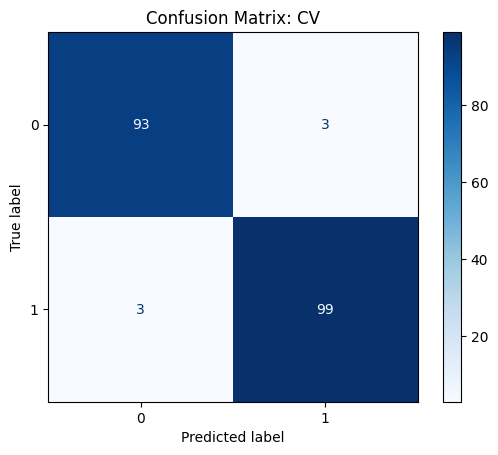

In [34]:
cm_cv = confusion_matrix(Y_cv, model.predict(X_cv))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cv, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: CV")
plt.show()

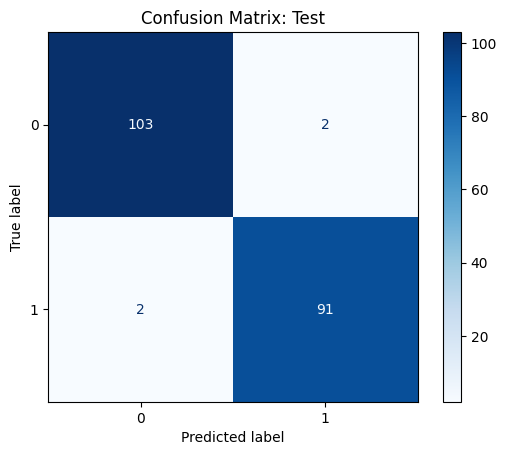

In [35]:
cm_test = confusion_matrix(Y_test, model.predict(X_test))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Test")
plt.show()